In [18]:
'''
파이토치 쿠다설정
https://blog.naver.com/me_a_me/223570004477

python = 3.11.11
torch = 2.6.0
cuda = 12.4
cudnn = 9.1.0.70

pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
'''

'\n파이토치 쿠다설정\nhttps://blog.naver.com/me_a_me/223570004477\n\npython = 3.11.11\ntorch = 2.6.0\ncuda = 12.4\ncudnn = 9.1.0.70\n\npip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124\n'

In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\qwer\.cache\kagglehub\datasets\birdy654\cifake-real-and-ai-generated-synthetic-images\versions\3


In [20]:
import os
import io
import cv2
import timm
import random

from PIL import Image
from tqdm.auto import tqdm  # Progress bars
from PIL import ImageFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset, random_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [21]:
# seed 값을 설정합니다.
seed = 0

# 파이썬 seed를 고정합니다.
random.seed(seed)   
# 넘파이 seed를 고정합니다.
np.random.seed(seed)
# 파이토치 seed와 cuda, cudnn 시드를 고정합니다.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True # 연산 결과를 결정적으로 만듦
torch.backends.cudnn.benchmark = False # 연산 성능 대신 일관성을 선택

In [22]:
import os

dataset_base_path = path
dataset_path_train_real = os.path.join(dataset_base_path, 'train/REAL')
dataset_path_train_fake = os.path.join(dataset_base_path, 'train/FAKE')
dataset_path_test_real = os.path.join(dataset_base_path, 'test/REAL')
dataset_path_test_fake = os.path.join(dataset_base_path, 'test/FAKE')

# 경로에서 이미지 파일 목록 가져오기
image_files_train_real = [f for f in os.listdir(dataset_path_train_real) if f.endswith(('.jpg', '.png'))]
image_files_test_real = [f for f in os.listdir(dataset_path_test_real) if f.endswith(('.jpg', '.png'))]
image_files_train_fake = [f for f in os.listdir(dataset_path_train_fake) if f.endswith(('.jpg', '.png'))]
image_files_test_fake = [f for f in os.listdir(dataset_path_test_fake) if f.endswith(('.jpg', '.png'))]

print(f"train_REAL 이미지 파일 수: {len(image_files_train_real)}")
print(f"test_REAL 이미지 파일 수: {len(image_files_test_real)}")
print(f"train_FAKE 이미지 파일 수: {len(image_files_train_fake)}")
print(f"test_FAKE 이미지 파일 수: {len(image_files_test_fake)}")

# 목록 합치기
image_files = image_files_train_real + image_files_train_fake + image_files_test_real + image_files_test_fake

print(f"이미지 파일 수: {len(image_files)}")

# 이후 코드는 image_files를 사용하여 진행
# ...

train_REAL 이미지 파일 수: 50000
test_REAL 이미지 파일 수: 10000
train_FAKE 이미지 파일 수: 50000
test_FAKE 이미지 파일 수: 10000
이미지 파일 수: 120000


In [23]:
#Dataset transformations are specified here

IMG_SIZE = 224  # Swin Transformer input size

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE), # 크기변경
    A.HorizontalFlip(p=0.5), # 좌우 뒤집기
    A.RandomBrightnessContrast(p=0.2), # 밝기와 대비 변경
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), # 정규화
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

In [24]:
#Custom dataloader
class CustomDataset(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=None)
        self.transform = transform

    def __getitem__(self, index):
        path, label = self.samples[index]
        image = Image.open(path).convert("RGB")
        image = np.array(image)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label


In [25]:
train_dataset = CustomDataset(root=os.path.join(dataset_base_path, 'train'), transform=train_transform)
test_dataset = CustomDataset(root=os.path.join(dataset_base_path, 'test'), transform=test_transform)

# test와 validation 데이터 분리
fake_samples = [sample for sample in test_dataset.samples if sample[1] == test_dataset.class_to_idx['FAKE']]
real_samples = [sample for sample in test_dataset.samples if sample[1] == test_dataset.class_to_idx['REAL']]
# test dataset을 validation과 test로 분할 (각각 10000개) real 5000개 fake5000개
real_validation_size = 5000
fake_validation_size = 5000
real_test_size = 5000
fake_test_size  = 5000

fake_validation_dataset, fake_test_dataset = random_split(fake_samples, [fake_validation_size, fake_test_size])
real_validation_dataset, real_test_dataset = random_split(real_samples, [real_validation_size, real_test_size])

# Subset을 사용하여 데이터셋 생성
validation_samples = [fake_samples[i] for i in fake_validation_dataset.indices] + [real_samples[i] for i in real_validation_dataset.indices]
test_samples = [fake_samples[i] for i in fake_test_dataset.indices] + [real_samples[i] for i in real_test_dataset.indices]

validation_dataset = Subset(test_dataset, [test_dataset.samples.index(sample) for sample in validation_samples])
test_dataset = Subset(test_dataset, [test_dataset.samples.index(sample) for sample in test_samples])

# 빠른 테스트를 위해 1000개만 불러오기 (real과 fake데이터 비율 안맞아서 고쳐야됨)
# indices = list(range(2000))
# train_dataset = Subset(train_dataset, indices)
# validation_dataset = Subset(validation_dataset, indices)
# test_dataset = Subset(test_dataset, indices)

print(len(train_dataset))
print(len(test_dataset))
print(len(validation_dataset))

100000
10000
10000


In [26]:
# # 클래스별 데이터 개수 확인
# test_labels = [sample[1] for sample in test_dataset]
# test_class_counts = Counter(test_labels)
# validation_labels = [sample[1] for sample in validation_dataset]
# validation_class_counts = Counter(validation_labels)

# # 클래스 이름으로 출력
# class_names = ["REAL", "FAKE"]#train_dataset.classes
# test_class_counts_by_name = {class_names[label]: count for label, count in test_class_counts.items()}
# print(f"test 데이터셋 클래스별 개수: {test_class_counts_by_name}")
# validation_class_counts_by_name = {class_names[label]: count for label, count in validation_class_counts.items()}
# print(f"Validation 데이터셋 클래스별 개수: {validation_class_counts_by_name}")

In [27]:
#이미지 메모리 제한 해제
Image.MAX_IMAGE_PIXELS = None

In [28]:
class SwinClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(SwinClassifier, self).__init__()
        self.model = timm.create_model('resnet18.a1_in1k', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

# cuda check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow loading truncated images

# Assume these variables are already defined:
# - train_dataset: your training dataset
# - test_dataset: your validation/test dataset
# - SwinClassifier: your model definition

# Set DataLoader parameters; using num_workers=0 for TPU stability
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Training hyperparameters
EPOCHS = 10 #에포크 10
PATIENCE = 10

# Define your model, loss, optimizer, and scheduler
model = SwinClassifier(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

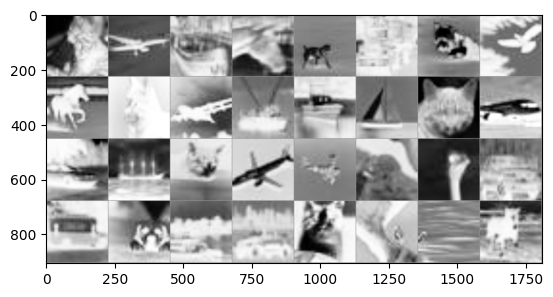

In [30]:
writer = SummaryWriter()
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# 임의의 학습 이미지를 가져옵니다
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
matplotlib_imshow(img_grid, one_channel=True) # one_channel=True는 흑백 이미지일 때 사용합니다.

# tensorboard에 기록합니다.
writer.add_image('images', img_grid)

writer.add_graph(model.to("cpu"), images)

In [31]:
def images_to_probs(net, images):
    '''
    학습된 신경망과 이미지 목록으로부터 예측 결과 및 확률을 생성합니다
    '''
    output = net(images).to("cpu")
    # 시그모이드를 통해 확률값 계산
    probs = torch.sigmoid(output)
    # 0.5를 기준으로 이진 분류
    preds = (probs > 0.5).float()
    
    # detach()를 사용하여 그래디언트 추적 중지 후 numpy 변환
    preds = preds.detach().squeeze().numpy()
    probs = probs.detach().squeeze().numpy()
    
    return preds, probs

def plot_classes_preds(net, images, labels):
    '''
    학습된 신경망과 배치로부터 가져온 이미지 / 라벨을 사용하여 matplotlib
    Figure를 생성합니다.
    '''
    preds, probs = images_to_probs(net, images)
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx].to("cpu"), one_channel=True) # one_channel=True는 흑백 이미지일 때 사용합니다.
        
        # 예측된 클래스와 확률을 표시
        pred_label = "FAKE" if preds[idx] >= 0.5 else "REAL"
        true_label = "FAKE" if labels[idx].item() == 1 else "REAL"
        
        ax.set_title(f"{pred_label}, {probs[idx]*100:.1f}%\n(label: {true_label})",
                    color=("green" if pred_label == true_label else "red"))
    return fig

In [32]:
# Checkpoint file path
checkpoint_file = "checkpoint.pth"
# checkpoint_file = "/content/gdrive/MyDrive/best_swin_model.pth"

# Initialize or resume training variables
start_epoch = 0
if os.path.exists(checkpoint_file):
    print("Checkpoint found. Resuming training from checkpoint...")
    # Load checkpoint to CPU first, then move state to device
    checkpoint = torch.load(checkpoint_file, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    epochs_no_improve = checkpoint['epochs_no_improve']
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    # Move the model to the device
    model.to(device)
else:
    best_val_loss = float("inf")
    epochs_no_improve = 0
    train_losses, val_losses = [], []

# Ensure model is on the correct device
model.to(device)

for epoch in range(start_epoch, EPOCHS):
    model.train() # Set model to training mode
    train_loss = 0.0
    correct = 0
    total = 0

    # Training loop with a progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training", leave=False)
    model.to(device)

    for images, labels in train_pbar:
        model.to(device)
        images = images.to(device)
        # labels는 BCEWithLogitsLoss를 위해 float 타입으로 변환하고 차원을 [batch_size, 1]로 확장
        labels = labels.to(device).float().unsqueeze(1) 

        optimizer.zero_grad()
        outputs = model(images) # outputs는 이제 [batch_size, 1] 형태의 로짓

        loss = criterion(outputs, labels) # BCEWithLogitsLoss 사용

        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        train_loss += loss.item() * batch_size

        # 이진 분류를 위한 예측 및 정확도 계산
        # 시그모이드 활성화 후 0.5를 기준으로 이진 분류
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += batch_size

        train_pbar.set_postfix({
            "Batch Loss": f"{loss.item():.4f}",
            "Avg Loss": f"{train_loss/total:.4f}",
            "Acc": f"{correct/total:.4f}"
        })
    epoch_train_loss = train_loss / total if total > 0 else 0
    train_losses.append(epoch_train_loss)
    train_acc = correct / total if total > 0 else 0
    # TensorBoard에 훈련 손실과 정확도 기록
    writer.add_scalar('train/loss', epoch_train_loss, epoch) # TensorBoard 경로 변경
    writer.add_scalar('train/accuracy', train_acc, epoch) # TensorBoard 경로 변경
    writer.add_figure('predictions vs. actuals',
                      plot_classes_preds(model, images, labels.squeeze()), # labels.squeeze()로 차원 축소
                      global_step=epoch * len(train_loader)) # plot_classes_preds 함수에 맞게 수정 필요
    writer.flush()

    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_pbar:
            images = images.to(device)
            # labels는 BCEWithLogitsLoss를 위해 float 타입으로 변환하고 차원을 [batch_size, 1]로 확장
            labels = labels.to(device).float().unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, labels) # BCEWithLogitsLoss 사용

            batch_size = images.size(0)
            val_loss += loss.item() * batch_size
            
            # 이진 분류를 위한 예측 및 정확도 계산
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += batch_size

            val_pbar.set_postfix({
                "Batch Loss": f"{loss.item():.4f}",
                "Avg Loss": f"{val_loss/total_val:.4f}",
                "Acc": f"{correct_val/total_val:.4f}"
            })

        epoch_val_loss = val_loss / total_val if total_val > 0 else 0
        val_losses.append(epoch_val_loss)
        val_acc = correct_val / total_val if total_val > 0 else 0

        writer.add_scalar('val/loss', epoch_val_loss, epoch) # TensorBoard 경로 변경
        writer.add_scalar('val/accuracy', val_acc, epoch) # TensorBoard 경로 변경
        writer.flush()
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save checkpoint after every epoch
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss,
        'epochs_no_improve': epochs_no_improve,
        'train_losses': train_losses,
        'val_losses': val_losses,
    }
    torch.save(checkpoint, checkpoint_file)
    # Also save a separate model file for each epoch if desired
    # torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth") # 각 에폭별 저장 원하면 주석 해제

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_swin_model.pth") # Save best model separately
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered. Validation loss did not improve for {PATIENCE} epochs. Training stopped.")
            break

    scheduler.step() # Learning rate scheduler step

print("Training complete!")

Epoch 1/10 Training:   0%|          | 0/3125 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "swin_transformer_real_fake.pth")

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import transforms # 사용되지 않으므로 필요 없으면 제거
from PIL import ImageFile # 사용되지 않으므로 필요 없으면 제거
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Assume that test_dataset and your model class SwinClassifier are already defined
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # device 정의 필요
# test_dataset = YourTestDataset(...) # test_dataset 정의 필요

BATCH_SIZE = 32
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# checkpoint_path = "swin_transformer_real_fake.pth"
checkpoint_path = "best_swin_model.pth"

# 모델 인스턴스 생성 시 num_classes를 1로 지정 (학습 시와 동일하게)
model = SwinClassifier(num_classes=1) 
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model.to(device)
model.eval() # 모델을 평가 모드로 설정

# Define the loss function (for consistency with training, even if not strictly needed for just inference)
# 학습 시 사용한 손실 함수와 동일하게 BCEWithLogitsLoss 사용
criterion = nn.BCEWithLogitsLoss() 

# Run testing/inference
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

test_pbar = tqdm(test_loader, desc="Testing", leave=False)
with torch.no_grad(): # 추론 시에는 기울기 계산 비활성화 (메모리 및 속도 효율)
    for images, labels in test_pbar:
        images = images.to(device)
        # labels는 BCEWithLogitsLoss를 위해 float 타입으로 변환하고 차원을 [batch_size, 1]로 확장
        # 실제 레이블을 저장할 때는 unsqueeze(1)된 형태가 아니라, 원래의 1차원 형태를 저장해야 합니다.
        labels_for_loss = labels.to(device).float().unsqueeze(1) 

        outputs = model(images) # outputs는 [batch_size, 1] 형태의 로짓

        # 손실 계산 (학습 시와 동일한 방식으로)
        loss = criterion(outputs, labels_for_loss)

        batch_size = images.size(0)
        test_loss += loss.item() * batch_size
        
        # 이진 분류를 위한 예측 및 정확도 계산 (학습 시와 동일하게)
        # 시그모이드 활성화 후 0.5를 기준으로 이진 분류
        # predicted는 [batch_size, 1] 형태의 0.0 또는 1.0 값을 가짐
        predicted_probs = torch.sigmoid(outputs)
        predicted_classes = (predicted_probs > 0.5).float() # 0.0 또는 1.0

        # 정확도 계산 시에는 차원 수를 맞춰서 비교합니다.
        # predicted_classes는 [batch_size, 1], labels는 [batch_size] -> labels를 unsqueeze(1)해서 비교
        correct += (predicted_classes == labels_for_loss).sum().item()
        total += batch_size

        # F1 Score 및 Confusion Matrix 계산을 위해 예측과 실제 레이블 저장
        # predicted_classes는 [batch_size, 1] 형태이므로, squeeze()하여 [batch_size] 형태로 만듦
        all_preds.extend(predicted_classes.cpu().numpy().squeeze()) 
        # labels는 원래 [batch_size] 형태였으므로 그대로 extend
        all_labels.extend(labels.cpu().numpy()) 

        test_pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

avg_loss = test_loss / total if total > 0 else 0
accuracy = correct / total if total > 0 else 0

# Calculate F1 score and confusion matrix
# all_labels와 all_preds는 이제 1차원 배열이므로 f1_score와 confusion_matrix에 바로 사용 가능
f1 = f1_score(all_labels, all_preds, average='binary') 
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

writer.close() # 테스트 코드에서는 보통 writer를 닫을 필요가 없습니다.
                 # 학습 스크립트의 마지막에 닫거나, 전역적으로 관리할 때만 사용합니다.

Test Loss: 0.0336, Test Accuracy: 0.9901, F1 Score: 0.9901
Confusion Matrix:
[[4947   53]
 [  46 4954]]
